<a href="https://colab.research.google.com/github/iesous-kurios/DS-Unit-2-Linear-Models/blob/master/module4-logistic-regression/GJW_assignment_regression_classification_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Watch Aaron's [video #1](https://www.youtube.com/watch?v=pREaWFli-5I) (12 minutes) & [video #2](https://www.youtube.com/watch?v=bDQgVt4hFgY) (9 minutes) to learn about the mathematics of Logistic Regression.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [0]:
# Do train/validate/test split. 
# Train on reviews from 2016 & earlier. 
# Validate on 2017. 
# Test on 2018 & later.
df.head(10)

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
5,Other,1/28/2016,NaN,NaN,NaN,6.99,4.0,NaN,NaN,NaN,NaN,NaN,3.0,4.0,5.0,3.5,2.5,2.5,2.5,4.0,1.0,NaN,NaN,NaN,NaN,x,x,NaN,x,NaN,x,NaN,NaN,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
6,California,1/30/2016,3.0,2.9,NaN,7.19,1.5,NaN,NaN,NaN,NaN,NaN,2.0,3.0,3.0,2.0,2.5,2.5,NaN,2.0,3.0,NaN,NaN,x,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
7,Carnitas,1/30/2016,NaN,NaN,NaN,6.99,4.0,NaN,NaN,NaN,NaN,NaN,2.5,3.0,3.0,2.5,3.0,3.5,NaN,2.5,3.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
8,California,2/1/2016,3.0,3.7,x,9.25,3.5,NaN,NaN,NaN,NaN,NaN,2.0,4.5,4.5,3.5,1.5,3.0,3.5,4.0,2.0,NaN,NaN,x,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
9,Asada,2/6/2016,4.0,4.1,NaN,6.25,3.5,NaN,NaN,NaN,NaN,NaN,2.5,1.5,1.5,3.0,4.5,3.0,1.5,2.0,4.5,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [0]:
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

In [0]:
df.Great.isnull().value_counts()

False    421
Name: Great, dtype: int64

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421 entries, 0 to 422
Data columns (total 59 columns):
Burrito           421 non-null object
Date              421 non-null datetime64[ns]
Yelp              87 non-null float64
Google            87 non-null float64
Chips             26 non-null object
Cost              414 non-null float64
Hunger            418 non-null float64
Mass (g)          22 non-null float64
Density (g/mL)    22 non-null float64
Length            283 non-null float64
Circum            281 non-null float64
Volume            281 non-null float64
Tortilla          421 non-null float64
Temp              401 non-null float64
Meat              407 non-null float64
Fillings          418 non-null float64
Meat:filling      412 non-null float64
Uniformity        419 non-null float64
Salsa             396 non-null float64
Synergy           419 non-null float64
Wrap              418 non-null float64
Unreliable        33 non-null object
NonSD             7 non-null object
Bee

In [0]:
df.Great = df.Great.astype(int)


In [0]:
df.Great.value_counts()

0    239
1    182
Name: Great, dtype: int64

(298, 59) (85, 59) (38, 59)


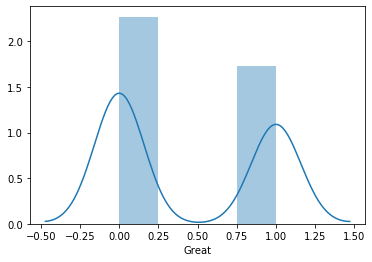

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
cutoff_train = pd.to_datetime('2017-01-01')
cutoff_val = pd.to_datetime('2018-01-01')
train = df[df.Date < cutoff_train]
val = df[(df.Date < cutoff_val) & (df.Date >= cutoff_train)]
test  = df[df.Date >= cutoff_val]
print(train.shape, validate.shape, test.shape)
sns.distplot(df['Great'])


In [0]:
# determine majority class
target = 'Great'
y_train = train[target]
y_train.value_counts(normalize=True)

0    0.590604
1    0.409396
Name: Great, dtype: float64

In [0]:
# guess majority class for each prediction
# TODO

majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)

In [0]:
# baseline accuracy if we guess majority class every prediction
from sklearn.metrics import accuracy_score
accuracy_score(y_train, y_pred)

0.5906040268456376

In [0]:
# baseline accuracy using validate data
y_val = val[target]
y_pred = [majority_class] * len(y_val)
accuracy_score(y_val, y_pred)


0.5529411764705883

In [0]:
train.describe()

,Yelp,Google,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Queso,Great
count,71.000000,71.000000,292.000000,297.000000,0.0,0.0,175.000000,174.000000,174.000000,298.000000,283.000000,288.000000,297.000000,292.000000,296.000000,278.000000,296.000000,296.000000,0.0,298.000000
mean,3.897183,4.142254,6.896781,3.445286,NaN,NaN,19.829886,22.042241,0.770920,3.472315,3.706360,3.551215,3.519024,3.528870,3.395946,3.324640,3.540203,3.955068,NaN,0.409396
std,0.478680,0.371738,1.211412,0.852150,NaN,NaN,2.081275,1.685043,0.137833,0.797606,0.991897,0.869483,0.850348,1.040457,1.089044,0.971226,0.922426,1.167341,NaN,0.492550
min,2.500000,2.900000,2.990000,0.500000,NaN,NaN,15.000000,17.000000,0.400000,1.400000,1.000000,1.000000,1.000000,0.500000,1.000000,0.000000,1.000000,0.000000,NaN,0.000000
25%,3.500000,4.000000,6.250000,3.000000,NaN,NaN,18.500000,21.000000,0.662500,3.000000,3.000000,3.000000,3.000000,3.000000,2.500000,2.500000,3.000000,3.500000,NaN,0.000000
50%,4.000000,4.200000,6.850000,3.500000,NaN,NaN,19.500000,22.000000,0.750000,3.500000,4.000000,3.500000,3.500000,4.000000,3.500000,3.500000,3.750000,4.000000,NaN,0.000000
75%,4.000000,4.400000,7.500000,4.000000,NaN,NaN,21.000000,23.000000,0.870000,4.000000,4.500000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,NaN,1.000000
max,4.500000,4.900000,11.950000,5.000000,NaN,NaN,26.000000,27.000000,1.240000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,NaN,1.000000


In [0]:
# 1. Import estimator class
from sklearn.linear_model import LinearRegression

# 2. Instantiate this class
linear_reg = LinearRegression()

# 3. Arrange X feature matrices (already did y target vectors)
features = ['Uniformity', 'Meat:filling', 'Fillings', 'Temp', 'Cost', 'Hunger', 'Tortilla']
X_train = train[features]
X_val = val[features]

# Impute missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

# 4. Fit the model
linear_reg.fit(X_train_imputed, y_train)

# 5. Apply the model to new data.
# The predictions look like this ...
linear_reg.predict(X_val_imputed)

## What do these numbers mean?

array([ 5.31776263e-01,  4.70192603e-01,  4.24718563e-01,  4.53003746e-01,
       -1.31374685e-03,  1.85533230e-01,  7.98069353e-01,  5.49946504e-01,
       -2.61673535e-03,  6.47939633e-01,  6.14856224e-01,  3.86434724e-01,
        3.18575022e-01,  2.95783145e-01,  9.11491725e-01,  3.27777689e-01,
        3.77997164e-01,  5.00753009e-01,  5.83197468e-01,  9.45661839e-01,
        6.94688148e-01,  4.12171554e-01,  1.28539472e-01,  5.09865839e-01,
        6.75431159e-01,  5.66486133e-01,  7.04282828e-01,  4.48402984e-01,
        4.99971450e-01,  5.12498176e-01,  7.25705900e-01,  4.05246024e-01,
        2.63520168e-01,  3.72558884e-01,  2.74865814e-01,  4.09886675e-01,
        5.61152102e-01,  5.56536943e-01,  6.17201486e-01,  5.85776667e-01,
        3.05728984e-01,  4.70022939e-01,  5.06848918e-01,  8.21347552e-01,
        4.74288607e-01,  4.51177750e-01,  9.20606529e-02,  3.69594445e-01,
        7.75920911e-01, -1.20949128e-01,  4.14760929e-02,  4.16929440e-01,
        6.82375995e-01,  

In [0]:
# Get coefficients
pd.Series(linear_reg.coef_, features)

## What do these numbers mean?

Uniformity      0.031936
Meat:filling    0.114000
Fillings        0.229506
Temp            0.066741
Cost            0.044815
Hunger          0.012886
Tortilla        0.074176
dtype: float64

In [0]:
test_case = [[19, 22, 3]]  # 19 inch long, circumference of 22, and 3 uniformity
linear_reg.predict(test_case)

## What does this number mean?

array([0.3425034])

In [0]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver='lbfgs')
log_reg.fit(X_train_imputed, y_train)
print('Validation Accuracy', log_reg.score(X_val_imputed, y_val))

Validation Accuracy 0.8


In [0]:
# The logistic sigmoid "squishing" function, 
# implemented to accept numpy arrays
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.e**(-x))

# 1 + np.e**(-2) 
1 + np.e**(-322222) 


1.0

In [0]:
sigmoid(log_reg.intercept_ + np.dot(log_reg.coef_, np.transpose(test_case)))

In [0]:
# TODO
!pip install category_encoders

In [0]:
df.columns

Index(['Burrito', 'Date', 'Yelp', 'Google', 'Chips', 'Cost', 'Hunger',
       'Mass (g)', 'Density (g/mL)', 'Length', 'Circum', 'Volume', 'Tortilla',
       'Temp', 'Meat', 'Fillings', 'Meat:filling', 'Uniformity', 'Salsa',
       'Synergy', 'Wrap', 'Unreliable', 'NonSD', 'Beef', 'Pico', 'Guac',
       'Cheese', 'Fries', 'Sour cream', 'Pork', 'Chicken', 'Shrimp', 'Fish',
       'Rice', 'Beans', 'Lettuce', 'Tomato', 'Bell peper', 'Carrots',
       'Cabbage', 'Sauce', 'Salsa.1', 'Cilantro', 'Onion', 'Taquito',
       'Pineapple', 'Ham', 'Chile relleno', 'Nopales', 'Lobster', 'Queso',
       'Egg', 'Mushroom', 'Bacon', 'Sushi', 'Avocado', 'Corn', 'Zucchini',
       'Great'],
      dtype='object')

In [0]:
# TODO
import category_encoders as ce 
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

target = 'Great'
features = ['Uniformity', 'Meat:filling', 'Fillings', 'Temp', 'Cost', 'Hunger', 'Tortilla']
X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
# X_train_encoded.head()

imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)
print ('Validation Accuracy', model.score(X_val_scaled,y_val))


Validation Accuracy 0.8


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


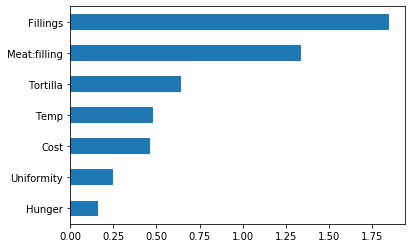

In [0]:
# TODO
%matplotlib inline
coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
coefficients.sort_values().plot.barh();

In [0]:
# 1. Import estimator class
from sklearn.linear_model import LinearRegression

# 2. Instantiate this class
linear_reg = LinearRegression()

# 3. Arrange X feature matrices (already did y target vectors)
features = ['Uniformity', 'Meat:filling', 'Fillings', 'Temp', 'Cost', 'Hunger', 'Tortilla']
X_train = train[features]
X_test = test[features]

# Impute missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# 4. Fit the model
linear_reg.fit(X_train_imputed, y_train)

# 5. Apply the model to new data.
# The predictions look like this ...
linear_reg.predict(X_test_imputed)

## What do these numbers mean?

array([ 1.13038321,  1.05281151, -0.0377752 ,  1.19254201,  0.20989199,
        0.35067225,  0.63404821,  0.87371447,  0.34666669,  0.70893637,
        0.85630737,  0.44051877,  0.79818604,  0.4817522 ,  0.64832128,
        0.66341317,  0.6517868 ,  0.18499184, -0.12397102,  0.2842136 ,
        0.09992699,  0.70052689,  0.67870456,  0.70870418,  0.5573803 ,
        0.24493686,  0.39012432,  1.10971831,  0.77341822,  0.57534716,
        0.33552482,  0.45965911,  0.57598965,  0.54361357,  0.57046962,
        0.44401933,  0.91107128,  0.67840945])

In [0]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver='lbfgs')
log_reg.fit(X_train_imputed, y_train)
print('Test Accuracy', log_reg.score(X_test_imputed, y_test))

Test Accuracy 0.7631578947368421
